<a href="https://colab.research.google.com/github/kagglechallengegroup18/Kaggle_Spaceship_Titanic/blob/release-1.0/Spaceship_RF_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [27]:
# Install required packages
!pip install missingno shap plotly -q

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import shap

In [29]:
# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

**Data Loading**

In [30]:
def load_data():
    train_url = "https://raw.githubusercontent.com/kagglechallengegroup18/Kaggle_Spaceship_Titanic/refs/heads/main/train.csv"
    test_url = "https://raw.githubusercontent.com/kagglechallengegroup18/Kaggle_Spaceship_Titanic/refs/heads/main/test.csv"
    train = pd.read_csv(train_url)
    test = pd.read_csv(test_url)
    return train, test

train_df, test_df = load_data()

**EDA AND VISUALIZATION**

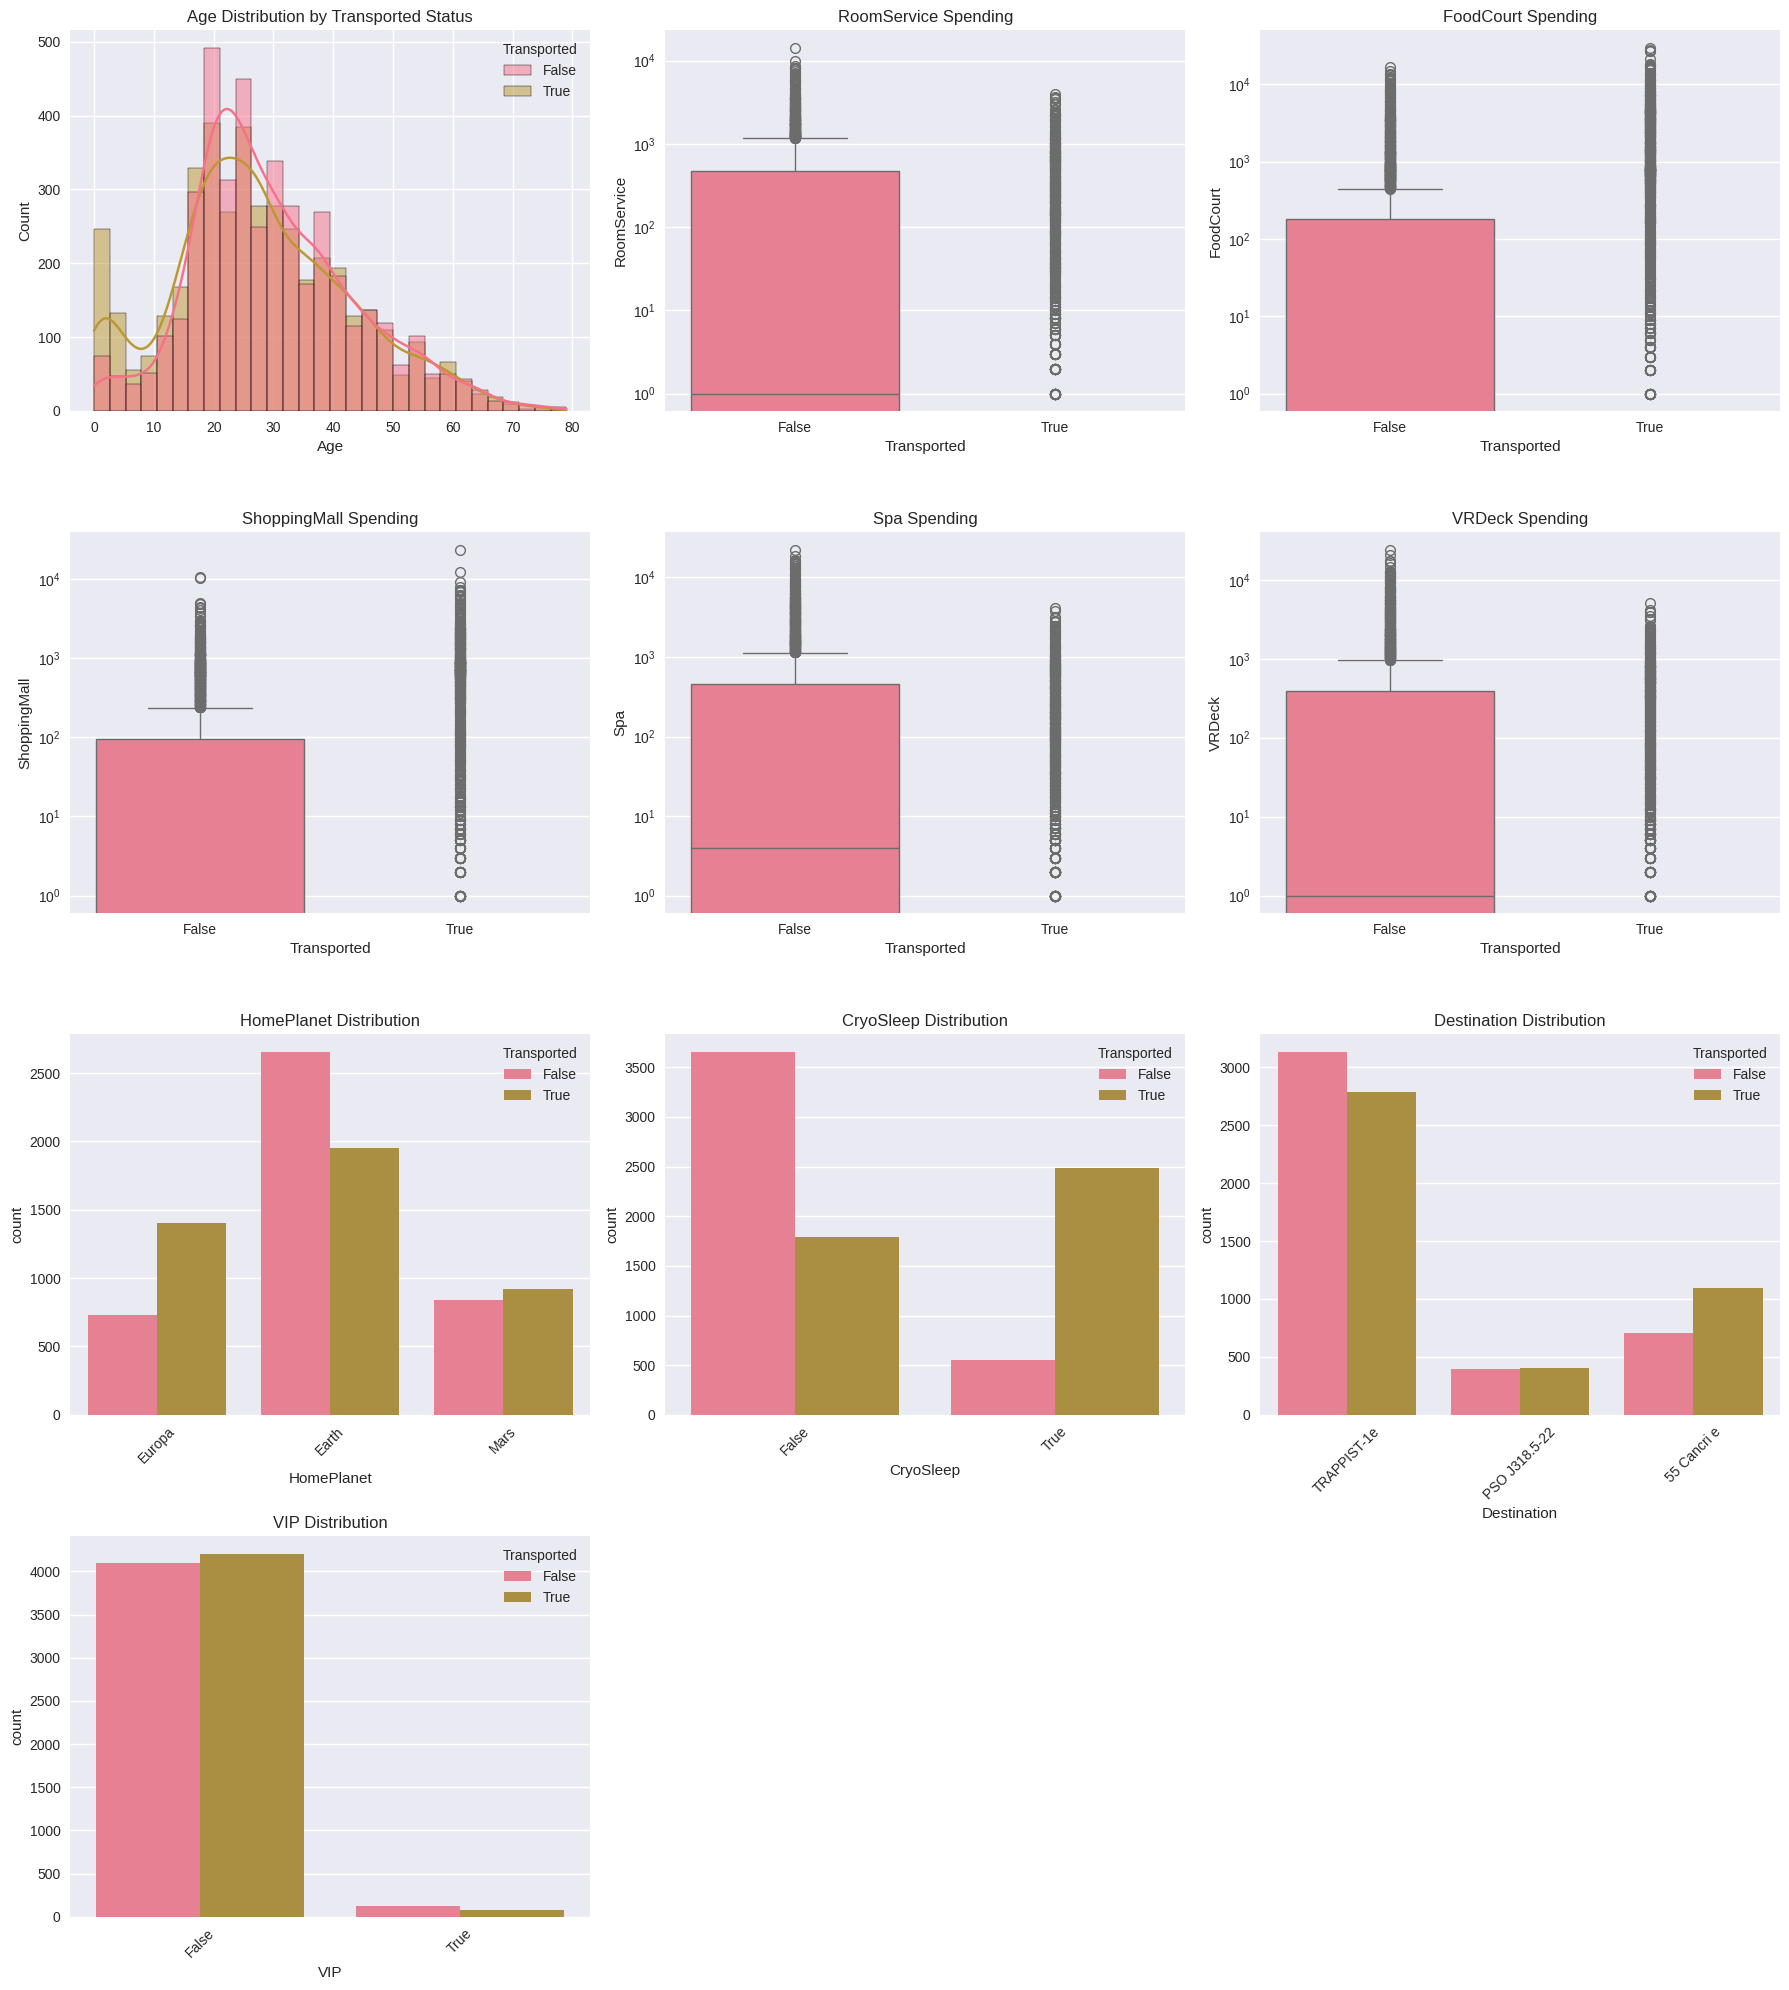

In [31]:
def plot_distributions(df):
    fig, axes = plt.subplots(4, 3, figsize=(18, 20)) # Increased rows to 4

    # Age distribution
    sns.histplot(data=df, x='Age', hue='Transported', bins=30, kde=True, ax=axes[0,0])
    axes[0,0].set_title('Age Distribution by Transported Status')

    # Spending features
    spending_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for i, feature in enumerate(spending_features): # Removed [:5] as it's not necessary
        sns.boxplot(data=df, x='Transported', y=feature, ax=axes[(i+1)//3, (i+1)%3])
        axes[(i+1)//3, (i+1)%3].set_title(f'{feature} Spending')
        axes[(i+1)//3, (i+1)%3].set_yscale('log')

    # Categorical features
    categoricals = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
    for i, feature in enumerate(categoricals):
        row = 2 + i // 3 # Calculate row index for categorical features
        col = i % 3    # Calculate column index for categorical features
        sns.countplot(data=df, x=feature, hue='Transported', ax=axes[row, col])
        axes[row, col].set_title(f'{feature} Distribution')
        axes[row, col].tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for i in range(len(categoricals), 3 * (4 - 2)): # Loop through remaining subplots in the last two rows
        fig.delaxes(axes[2 + i // 3, i % 3]) # Adjusted row calculation

    plt.tight_layout()
    plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_distributions(train_df)

**Feature Engineering**

In [32]:
def engineer_features(df):
    # Cabin features
    df['Cabin'] = df['Cabin'].fillna('Unknown/0/U')
    df[['Deck', 'CabinNum', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')

    # Total spending
    spending_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['TotalSpending'] = df[spending_features].sum(axis=1)
    df['HasSpending'] = (df['TotalSpending'] > 0).astype(int)

    # Age bins
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 25, 40, 60, 100],
                           labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'MiddleAged', 'Senior'])

    # Family features
    df[['GroupId', 'PersonId']] = df['PassengerId'].str.split('_', expand=True)
    group_sizes = df.groupby('GroupId')['GroupId'].transform('count')
    df['GroupSize'] = group_sizes
    df['IsAlone'] = (df['GroupSize'] == 1).astype(int)

    # Drop unnecessary columns
    df.drop(columns=['Name', 'Cabin', 'PassengerId', 'GroupId', 'PersonId'], inplace=True)

    return df

train_df = engineer_features(train_df)
test_df = engineer_features(test_df)

**Preprocessing**

In [33]:
def preprocess_data(train, test):
    # Define columns
    numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinNum', 'TotalSpending', 'GroupSize']
    categorical_columns = ['CryoSleep', 'HomePlanet', 'Destination', 'VIP', 'Deck', 'Side', 'AgeGroup', 'HasSpending', 'IsAlone']

    # Impute numericals
    knn_imputer_num = KNNImputer(n_neighbors=5)
    train[numerical_columns] = knn_imputer_num.fit_transform(train[numerical_columns])
    test[numerical_columns] = knn_imputer_num.transform(test[numerical_columns])

    # Process categoricals
    for col in categorical_columns:
        # Convert to string first
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)

        # Fill NA
        train[col] = train[col].fillna('Unknown')
        test[col] = test[col].fillna('Unknown')

        # Encode
        le = LabelEncoder()
        train[col] = le.fit_transform(train[col])
        test[col] = le.transform(test[col])

    # One-hot encode
    train = pd.get_dummies(train, columns=categorical_columns, drop_first=True)
    test = pd.get_dummies(test, columns=categorical_columns, drop_first=True)

    # Align columns
    missing_cols = set(train.columns) - set(test.columns)
    for col in missing_cols:
        if col != 'Transported':
            test[col] = 0

    extra_cols = set(test.columns) - set(train.columns)
    for col in extra_cols:
        test.drop(col, axis=1, inplace=True)

    # Ensure same column order
    test = test[train.drop('Transported', axis=1).columns]

    return train, test

train_df, test_df = preprocess_data(train_df, test_df)

In [34]:
# Prepare data
X = train_df.drop('Transported', axis=1)
y = train_df['Transported'].astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [35]:
# Hyperparameter Tuning
def tune_hyperparameters(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                              cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)

    return grid_search.best_estimator_



#  Best parameters found for tuning

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=4,
    max_features='sqrt',
    random_state=42
)
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=12, min_samples_split=4, n_estimators=300,
                       random_state=42)

Validation Accuracy: 0.7947096032202415

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       863
           1       0.80      0.79      0.79       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



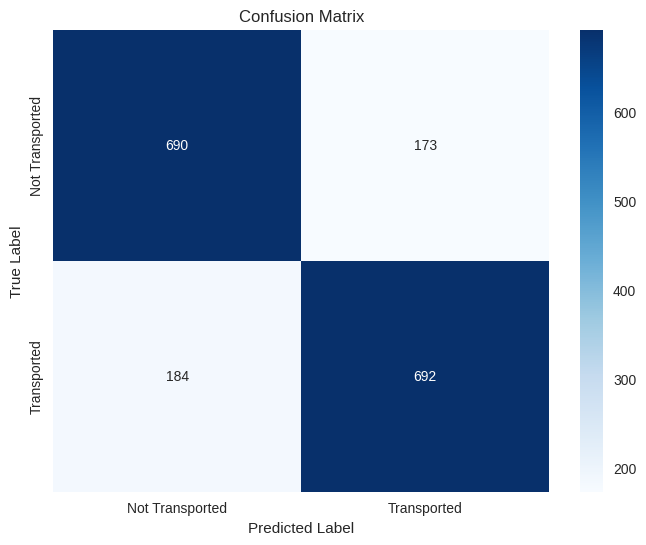

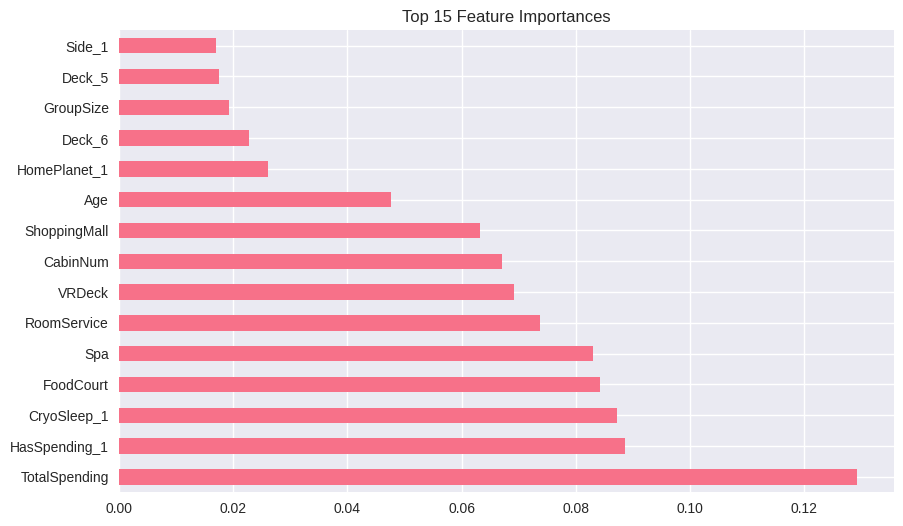

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

In [36]:
# Evaluation
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    # Metrics
    print("Validation Accuracy:", accuracy_score(y_val, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Transported', 'Transported'],
                yticklabels=['Not Transported', 'Transported'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Feature Importance
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    top_features = feat_importances.nlargest(15)
    plt.figure(figsize=(10,6))
    top_features.plot(kind='barh')
    plt.title('Top 15 Feature Importances')
    plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')
    plt.show()

    # SHAP values (sample 100 instances for speed)
    explainer = shap.TreeExplainer(model)
    X_val_sample = X_val.iloc[:100]
    shap_values_sample = explainer.shap_values(X_val_sample)
    plt.figure()
    shap.summary_plot(shap_values_sample, X_val_sample, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance')
    plt.savefig('shap_importance.png', dpi=300, bbox_inches='tight')
    plt.close()

    plt.figure()
    shap.summary_plot(shap_values_sample, X_val_sample, show=False)
    plt.title('SHAP Summary Plot')
    plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
    plt.close()

evaluate_model(model, X_val, y_val)

In [37]:
# Predict on test set
# Load the original test data to retain PassengerId
original_test_df = pd.read_csv("https://raw.githubusercontent.com/kagglechallengegroup18/Kaggle_Spaceship_Titanic/refs/heads/main/test.csv")

# Ensure the processed test_df used for prediction has the same columns as the training data (excluding the target)
X_test_final = test_df[X.columns] # Use the columns from the training data

test_preds = model.predict(X_test_final)

# Prepare submission
submission = pd.DataFrame({
    "PassengerId": original_test_df["PassengerId"],
    "Transported": test_preds.astype(bool)
})
submission.to_csv("submission_randomforest_optimized.csv", index=False)
print("Created: submission_randomforest_optimized.csv")

Created: submission_randomforest_optimized.csv


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col].astype(str))
        test_df[col] = le.transform(test_df[col].astype(str))

# Prepare features and target
X = train_df.drop(columns=['PassengerId', 'Transported', 'Name', 'Cabin'], errors='ignore')
y = train_df['Transported'].astype(int)
X_test_final = test_df.drop(columns=['PassengerId', 'Name', 'Cabin'], errors='ignore')

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Optimized Random Forest model
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=4,
    max_features='sqrt',
    random_state=42
)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_val)
print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))


Random Forest Results:
Accuracy: 0.7837837837837838
F1 Score: 0.7875706214689265
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.77      0.78       861
           1       0.78      0.79      0.79       878

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



In [39]:
# Generate Kaggle submission
# Load the original test data to retain PassengerId
original_test_df = pd.read_csv("https://raw.githubusercontent.com/kagglechallengegroup18/Kaggle_Spaceship_Titanic/refs/heads/main/test.csv")

test_preds = model.predict(X_test_final)
submission = pd.DataFrame({
    "PassengerId": original_test_df["PassengerId"],
    "Transported": test_preds.astype(bool)
})
submission.to_csv("submission_randomforest_optimized.csv", index=False)
print("Created: submission_randomforest_optimized.csv")

Created: submission_randomforest_optimized.csv


In [40]:
# STEP 1: Label Encoding for Categorical Columns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Apply Label Encoding to both train and test datasets
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col].astype(str))
        test_df[col] = le.transform(test_df[col].astype(str))


In [41]:
# STEP 2: Prepare Features and Target Variable
X = train_df.drop(columns=['PassengerId', 'Transported', 'Name', 'Cabin'], errors='ignore')
y = train_df['Transported'].astype(int)

X_test_final = test_df.drop(columns=['PassengerId', 'Name', 'Cabin'], errors='ignore')

# Split training data into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [42]:
# STEP 3: Train Optimized Random Forest Model
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=4,
    max_features='sqrt',
    random_state=42
)

model.fit(X_train, y_train)


RandomForestClassifier(max_depth=12, min_samples_split=4, n_estimators=300,
                       random_state=42)

In [43]:
# STEP 4: Evaluate the Model

y_pred = model.predict(X_val)

print("Random Forest Evaluation Results:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))


Random Forest Evaluation Results:
Accuracy: 0.7837837837837838
F1 Score: 0.7875706214689265
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.77      0.78       861
           1       0.78      0.79      0.79       878

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



In [44]:
# STEP 5: Generate Submission CSV for Kaggle
# Load the original test data to retain PassengerId
original_test_df = pd.read_csv("https://raw.githubusercontent.com/kagglechallengegroup18/Kaggle_Spaceship_Titanic/refs/heads/main/test.csv")

test_preds = model.predict(X_test_final)

submission = pd.DataFrame({
    "PassengerId": original_test_df["PassengerId"],
    "Transported": test_preds.astype(bool)
})

submission.to_csv("submission_randomforest_optimized.csv", index=False)
print(" Created: submission_randomforest_optimized.csv")

 Created: submission_randomforest_optimized.csv


**LightGBM**

In [45]:

# STEP 1: Install LightGBM if using Colab
# !pip install lightgbm

from lightgbm import LGBMClassifier

# STEP 2: Reuse same features from RF section

lgb_model = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.03,
    max_depth=8,
    num_leaves=31,
    colsample_bytree=0.9,
    subsample=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1952
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

LGBMClassifier(colsample_bytree=0.9, learning_rate=0.03, max_depth=8,
               n_estimators=400, random_state=42, subsample=0.8)

In [46]:
# STEP 3: Evaluate LightGBM
lgb_preds = lgb_model.predict(X_val)

print("LightGBM Evaluation Results:")
print("Accuracy:", accuracy_score(y_val, lgb_preds))
print("F1 Score:", f1_score(y_val, lgb_preds))
print("Classification Report:\n", classification_report(y_val, lgb_preds))


LightGBM Evaluation Results:
Accuracy: 0.8033352501437608
F1 Score: 0.8045714285714286
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80       861
           1       0.81      0.80      0.80       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



In [47]:
# STEP 4: Generate Kaggle submission file from LightGBM
lgb_test_preds = lgb_model.predict(X_test_final)

# Load the original test data to retain PassengerId
original_test_df = pd.read_csv("https://raw.githubusercontent.com/kagglechallengegroup18/Kaggle_Spaceship_Titanic/refs/heads/main/test.csv")

lgb_submission = pd.DataFrame({
    "PassengerId": original_test_df["PassengerId"],
    "Transported": lgb_test_preds.astype(bool)
})

lgb_submission.to_csv("submission_lightgbm.csv", index=False)
print("submission_lightgbm.csv is ready for upload!")

submission_lightgbm.csv is ready for upload!
